<a href="https://colab.research.google.com/github/ReidelVichot/PUS2022_RVichot/blob/main/HW5/HW5_timeSeriesClustering_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering analysis on population trends

You are clustering the "shape" of time series to find trends, specifically, population growth trends. Do any countries stand out in the population growth trends in the past 60 years? are there groups of countries that have similar trends (and why?)

NOTE: your clusters may not be identical to mine!
## Imports

In [120]:
import pandas as pd
import pylab as pl
import numpy as np

from sklearn import preprocessing
from sklearn import cluster

pl.rcParams['font.size'] = 12

do this to read an excel file with python
then restart the notebook

In [121]:
pip install xlrd==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data processing

## Get the data

I wanted the data to be gotten from the WorldBank API directly but the link is down tonight (11/2) so I put the file on the shared drive. Mount your google drive and get it from `/content/drive/Shareddrives/PUS2022/data`. The file name is `SP.POP.TOTL?downloadformat=excel`

You are going to have to skip some rows (`skiprows=`) and ideally only use relevant columns (the country name and each year column from 1960, you can use `usecold=` or you can read everything in then throw away the columns you do not need). 

Finally, set the country name as the index for this dataframe. you can do that with `set_index()` passing the relevant column name as the argument (dont forget that you want to do it inplace! `inplace=True`)

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
cd /content/drive/Shareddrives/PUS2022/data

/content/drive/Shareddrives/PUS2022/data


In [124]:
#reading in the data
pop_df = pd.read_excel('SP.POP.TOTL?downloadformat=excel', skiprows=3)
columns = ['Country Name', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020']    
pop_df = pop_df[columns]  
pop_df.set_index("Country Name", inplace=True)                 
pop_df

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country Name,,,,,,,,,,,,,,,,,,,,,
Aruba,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,57702.0,58044.0,58377.0,58734.0,...,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0
Africa Eastern and Southern,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,152752671.0,156876454.0,161156430.0,165611760.0,...,532760424.0,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0
Afghanistan,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,10174840.0,10399936.0,10637064.0,10893772.0,...,30117411.0,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0
Africa Western and Central,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,109701811.0,112195950.0,114781116.0,117468741.0,...,360285439.0,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0
Angola,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,5781305.0,5774440.0,5771973.0,5803677.0,...,24220660.0,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kosovo,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,1163000.0,1191000.0,...,1791000.0,1807106.0,1818117.0,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1775378.0
"Yemen, Rep.",5315351.0,5393034.0,5473671.0,5556767.0,5641598.0,5727745.0,5816241.0,5907873.0,6001858.0,6097042.0,...,23807586.0,24473176.0,25147112.0,25823488.0,26497881.0,27168210.0,27834811.0,28498683.0,29161922.0,29825968.0
South Africa,17099836.0,17524533.0,17965733.0,18423157.0,18896303.0,19384838.0,19888259.0,20406863.0,20942147.0,21496075.0,...,52003759.0,52832659.0,53687125.0,54544184.0,55386369.0,56207649.0,57009751.0,57792520.0,58558267.0,59308690.0


##Data Cleaning 
remove NaNs, remove any unwanted columns

In [125]:
from pandas.core.ops.array_ops import Any

# I recommend you drop any column that is all NoN and any row that has any NaN 
# you control this (dropping only if all are, vs dropping if any is) with the keyord "any" of .dropna()
pop_df_clean = pop_df.dropna()


In [126]:
# looking a little at the data
pop_df_clean.shape

(262, 61)

In [127]:
pop_df_clean.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country Name,,,,,,,,,,,,,,,,,,,,,
Aruba,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,57702.0,58044.0,58377.0,58734.0,...,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0
Africa Eastern and Southern,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,152752671.0,156876454.0,161156430.0,165611760.0,...,532760424.0,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0
Afghanistan,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,10174840.0,10399936.0,10637064.0,10893772.0,...,30117411.0,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0
Africa Western and Central,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,109701811.0,112195950.0,114781116.0,117468741.0,...,360285439.0,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0
Angola,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,5781305.0,5774440.0,5771973.0,5803677.0,...,24220660.0,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0


In [128]:
pop_df_clean.tail()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country Name,,,,,,,,,,,,,,,,,,,,,
Kosovo,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,1163000.0,1191000.0,...,1791000.0,1807106.0,1818117.0,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1775378.0
"Yemen, Rep.",5315351.0,5393034.0,5473671.0,5556767.0,5641598.0,5727745.0,5816241.0,5907873.0,6001858.0,6097042.0,...,23807586.0,24473176.0,25147112.0,25823488.0,26497881.0,27168210.0,27834811.0,28498683.0,29161922.0,29825968.0
South Africa,17099836.0,17524533.0,17965733.0,18423157.0,18896303.0,19384838.0,19888259.0,20406863.0,20942147.0,21496075.0,...,52003759.0,52832659.0,53687125.0,54544184.0,55386369.0,56207649.0,57009751.0,57792520.0,58558267.0,59308690.0
Zambia,3070780.0,3164330.0,3260645.0,3360099.0,3463211.0,3570466.0,3681953.0,3797877.0,3918872.0,4045740.0,...,14023199.0,14465148.0,14926551.0,15399793.0,15879370.0,16363449.0,16853608.0,17351714.0,17861034.0,18383956.0
Zimbabwe,3776679.0,3905038.0,4039209.0,4178726.0,4322854.0,4471178.0,4623340.0,4779825.0,4941901.0,5111326.0,...,12894323.0,13115149.0,13350378.0,13586710.0,13814642.0,14030338.0,14236599.0,14438812.0,14645473.0,14862927.0


## Scaling (standardizing)

Standardize the data: you are working with time series so you want each datapoint (=each country) to be mean 0 and standard deviaion 1 along the rows (that is axis 1)

You can use the `preprocessing.scale` function. Make sure you check! you want eavery country mean to be 0 and every country standard deviation to be 1...

In [129]:
# standardizing the data
X= pop_df_clean.values
pop_standard = preprocessing.scale(X, axis=1, with_mean = True, with_std = True)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


## Visualize the data

make a plot of the time series before scaling, and after scaling. What do you see in the scaled version that was lost before? Dont forget to write a caption!

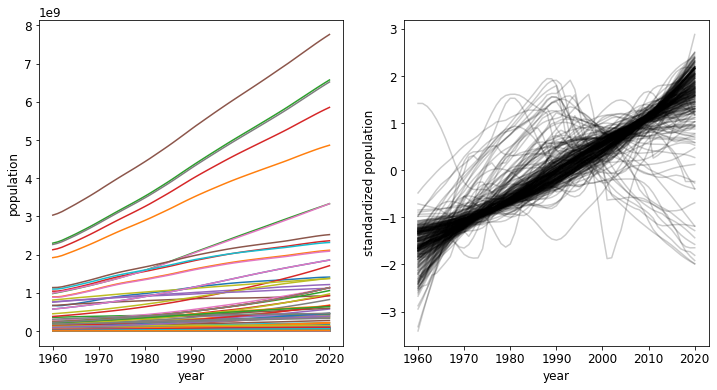

In [130]:
# looking at the data
fig, ax = pl.subplots(1,2, figsize=(12,6))
pop_df_clean.T.plot(legend=False, ax=ax[0])
ax[1].plot(pop_standard.T, color="k", alpha=0.2)

ax[0].set_xlabel("year")
ax[0].set_ylabel("population")
ax[1].set_xlabel("year")
ax[1].set_ylabel("standardized population")
ax[1].set_xticks(range(0,70,10))
ax[1].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);

**Fig**. 1: These figures show changes in population by year. The image to the left shows the population (in billions) of differenct countries (each country represented by a color) from the year 1960 to 2020. The figure to the right shows the population of each year and country in standarized units. 

# Make a cluster model with KMeans
Use kmeans (`sklearn.cluster.KMeans`) to cluster the data. Make 9 models for number of clusters = 2, 3, 4, 5, 6, 7, 8, 9, 10. 

For each model, fit the data and calculate the "inertia" which is 

# Use an elbow plot to figure out ideal cluster _n_ 

In [131]:
# For n_clusters = 2 this would look as:
model = cluster.KMeans(n_clusters = 2)
model.fit(pop_standard)
model.inertia_

1249.5287124898719

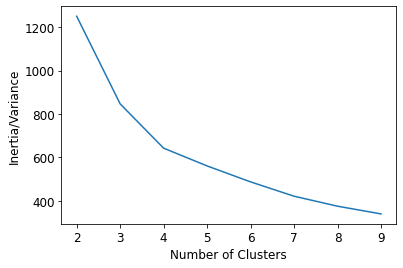

In [132]:
# use the "inertia" (intracluster variance essentially) to make an Elbow plot: 
# inertia is the y axis, the number of clusters are the x axis.
# assess if the elbow plot shows an inflection, which you can use to determin the "right" number of clusters
inertia = []
for i in range(2, 10): 
  model = cluster.KMeans(n_clusters = i)
  model.fit(pop_standard)
  
  inertia.append(model.inertia_)

pl.plot(range(2, 10), inertia)
pl.xlabel("Number of Clusters")
pl.ylabel("Inertia/Variance");

Figure 2: "Elbow plot" of k-means clustering of our time series. The y axis shows the sum of squared distances to the closest centroid (scikit calls this "inertia", Fed called it "variance"). The point where inertia/variance dramatically drops in an elbow plot is recommended as the preferred number of clusters; this line has a bit too much of a gradual descent to make an effective recommendation. I'm just going to keep using 4 because that's what we used in class. 

## Pick a model
Pick the model you prefer from the suite of models above, plot the data for each cluster separately. 
If for example you have made 4 clusters, then you fould do:

```
fig,ax = pl.subplots(2,2, figsize=(12,14))


ax[0,0].set_title("Cluster 1")
ax[0,0].set_xticks(range(0,70,10))
ax[0,0].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[0,0].plot(pop_standard[model.label_[1] == 0].T, "k", alpha=0.2);
ax[0,0].plot(c[0][0], color="hotpink")

ax[0,1]....

ax[1,0]....

ax[1,1]....
```

In [133]:
# For n_clusters = 2 this would look as:
model = cluster.KMeans(n_clusters = 4)
model.fit(pop_standard)
model.inertia_

642.2296550573025

In [134]:
model.labels_

array([0, 0, 0, 0, 0, 2, 3, 0, 0, 3, 2, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 1,
       0, 3, 1, 2, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 0, 3, 3, 3, 0, 0, 0,
       0, 3, 0, 0, 3, 3, 2, 2, 0, 0, 2, 3, 3, 2, 0, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 3, 3, 1, 0, 3, 0, 3, 3, 3, 2, 3, 0, 0, 1, 0, 3, 0, 0, 0, 0,
       3, 0, 2, 0, 3, 2, 3, 3, 0, 0, 1, 0, 1, 3, 3, 0, 0, 3, 0, 3, 3, 0,
       3, 0, 0, 0, 3, 3, 0, 2, 2, 0, 3, 0, 0, 0, 3, 3, 0, 0, 0, 3, 3, 3,
       0, 0, 3, 3, 3, 3, 3, 3, 1, 0, 1, 0, 3, 3, 0, 2, 0, 0, 0, 3, 3, 3,
       2, 0, 0, 3, 3, 2, 3, 3, 0, 0, 3, 0, 0, 3, 0, 3, 0, 0, 3, 3, 0, 3,
       3, 0, 3, 0, 0, 0, 0, 3, 3, 3, 0, 2, 0, 2, 3, 3, 3, 3, 3, 3, 0, 1,
       2, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       3, 3, 3, 3, 0, 0, 3, 3, 0, 3, 0, 3, 3, 0, 3, 2, 3, 0, 3, 3, 3, 3,
       0, 0, 1, 3, 3, 3, 3, 2, 3, 0, 2, 3, 0, 3, 3, 2, 0, 3, 0, 3],
      dtype=int32)

In [135]:
# time for a k-means cluster!!
c = model.cluster_centers_



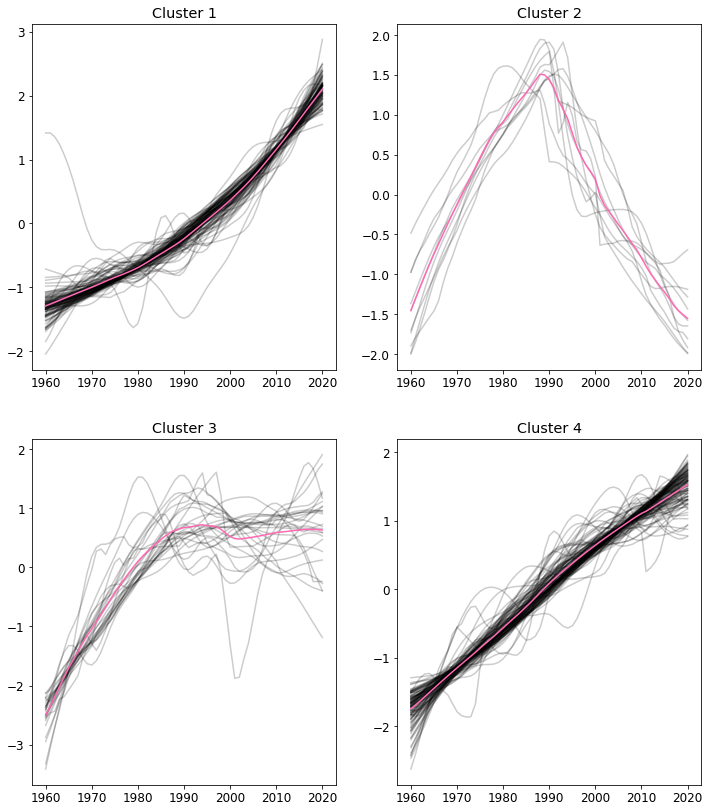

In [136]:
fig,ax = pl.subplots(2,2, figsize=(12,14))


ax[0,0].set_title("Cluster 1")
ax[0,0].set_xticks(range(0,70,10))
ax[0,0].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[0,0].plot(pop_standard[model.labels_ == 0].T, "k", alpha=0.2);
ax[0,0].plot(c[0], color="hotpink")

ax[0,1].set_title("Cluster 2")
ax[0,1].set_xticks(range(0,70,10))
ax[0,1].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[0,1].plot(pop_standard[model.labels_ == 1].T, "k", alpha=0.2);
ax[0,1].plot(c[1], color="hotpink")

ax[1,0].set_title("Cluster 3")
ax[1,0].set_xticks(range(0,70,10))
ax[1,0].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[1,0].plot(pop_standard[model.labels_ == 2].T, "k", alpha=0.2);
ax[1,0].plot(c[2], color="hotpink")

ax[1,1].set_title("Cluster 4")
ax[1,1].set_xticks(range(0,70,10))
ax[1,1].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[1,1].plot(pop_standard[model.labels_ == 3].T, "k", alpha=0.2);
ax[1,1].plot(c[3], color="hotpink")

# Extra Credit: do it with anothe cluster method, agglomerative clustering or DBScan 

In [144]:
# For n_clusters = 4 this would look as:
model = cluster.AgglomerativeClustering(n_clusters = 4)
model.fit(pop_standard)
model.labels_


AgglomerativeClustering(n_clusters=4)

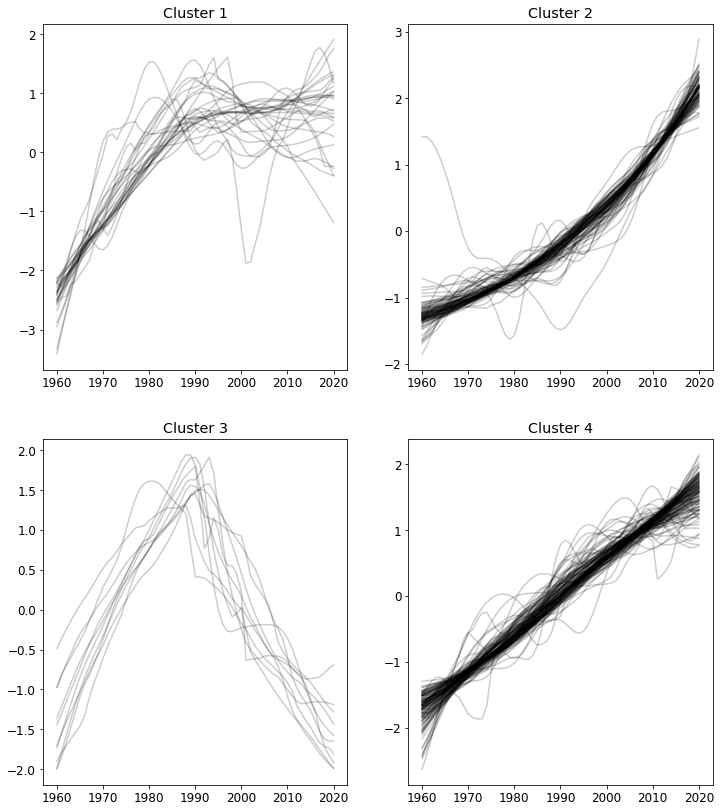

In [148]:
fig,ax = pl.subplots(2,2, figsize=(12,14))


ax[0,0].set_title("Cluster 1")
ax[0,0].set_xticks(range(0,70,10))
ax[0,0].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[0,0].plot(pop_standard[model.labels_ == 0].T, "k", alpha=0.2);
#ax[0,0].plot(c[0], color="hotpink")

ax[0,1].set_title("Cluster 2")
ax[0,1].set_xticks(range(0,70,10))
ax[0,1].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[0,1].plot(pop_standard[model.labels_ == 1].T, "k", alpha=0.2);
#ax[0,1].plot(c[1], color="hotpink")

ax[1,0].set_title("Cluster 3")
ax[1,0].set_xticks(range(0,70,10))
ax[1,0].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[1,0].plot(pop_standard[model.labels_ == 2].T, "k", alpha=0.2);
#ax[1,0].plot(c[2], color="hotpink")

ax[1,1].set_title("Cluster 4")
ax[1,1].set_xticks(range(0,70,10))
ax[1,1].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[1,1].plot(pop_standard[model.labels_ == 3].T, "k", alpha=0.2);
#ax[1,1].plot(c[3], color="hotpink")

how many objects in each cluster?

In [149]:
for i in range(4):
  print ("total items in cluster {:d}: {:d}".format(
      i+1, np.sum(model.labels_ == i)))

total items in cluster 1: 28
total items in cluster 2: 96
total items in cluster 3: 10
total items in cluster 4: 128


Figure 3: Results of using k-means clustering on the standardized data seen in Figure 1. The mean line for each cluster is visible in pink.

Cluster 1 is a a fairly linear upward trend with some outliers and cluster 4 a more curved upward trend. Cluster 2 and cluster 4 have fewer time series; 2 rises steadily before a big drop in the 1990s whereas the countries in 3 kind of hit a plateau around the 1990s. 

# Identifying the countries in the smallest clusters

plot the two smallest clusters with labels for the countries

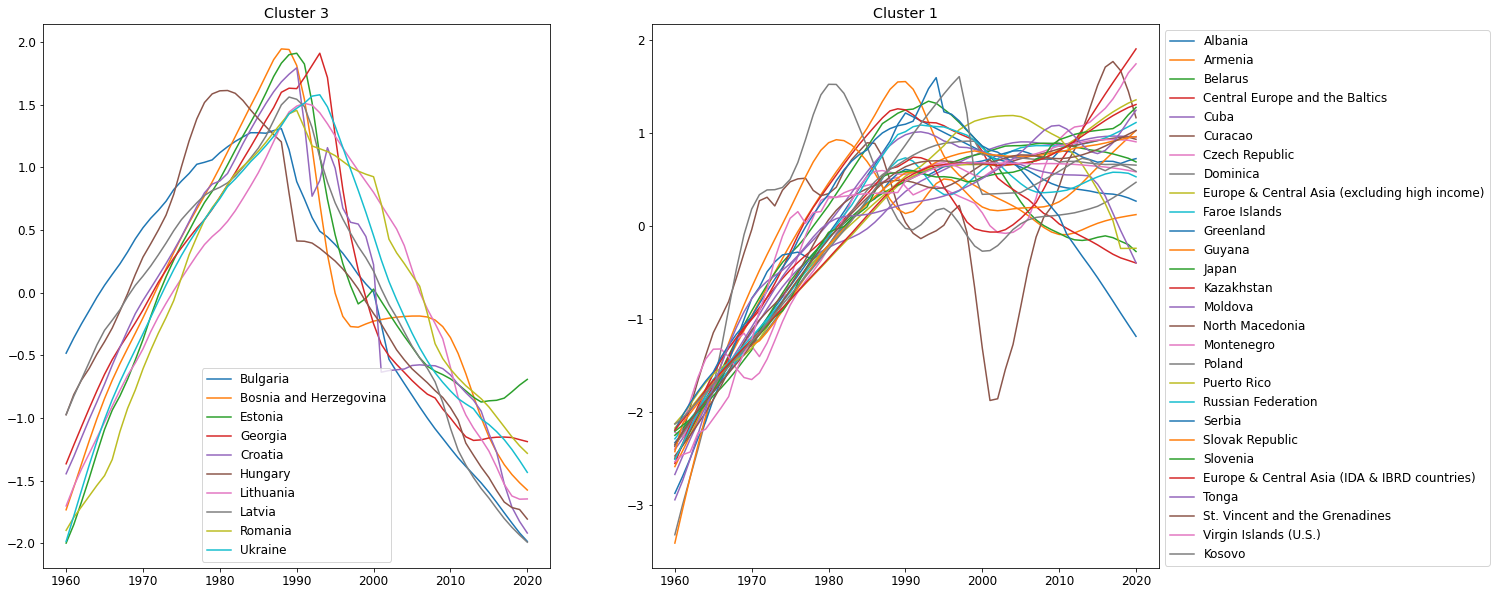

In [153]:
fig,ax = pl.subplots(1,2, figsize=(20,10))

ax[1].set_title("Cluster 1")
ax[1].set_xticks(range(0,70,10))
ax[1].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[1].plot(pop_standard[model.labels_ == 0 ].T);
ax[1].legend(labels=pop_df_clean.loc[model.labels_ == 0].index, bbox_to_anchor=(1.0, 1.0), loc='upper left')


ax[0].set_title("Cluster 3")
ax[0].set_xticks(range(0,70,10))
ax[0].set_xticklabels(["%d"%i for i in range(1960, 2030, 10)]);
ax[0].plot(pop_standard[model.labels_ == 2 ].T);
# placing legend method via https://www.delftstack.com/howto/matplotlib/how-to-place-legend-outside-of-the-plot-in-matplotlib/

ax[0].legend(labels=pop_df_clean.loc[model.labels_ == 2].index)


Figure 4: This figure shows the countries that cluster together in the smallest clusters of the sample. These two clusters are include the countries that either had a decline in population or did not have population increases. 

Can you do some library research to figure out why those countries may cluster together?

In both cases the inflection point was around the 1990. This year was characterized by the fall of the Soviet Union that ended up in a crisis in Eastern Europe and other socialist countries.